<a href="https://colab.research.google.com/github/laurakrama/ADE2024/blob/main/cadernoMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3A - Baixe os dados dos CMEIs (ou outro dado pontual) de Curitiba do site do IPPUC e faça um mapa com os bairros, os pontos, o mapa de calor e os clusters. Pode ser feito também com dados do OpenStreetMap, baixados no QGIS com o complemento QuickOSM.
https://ippuc.org.br/geodownloads/geo.htm

---



In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

#! pip install geopandas

import folium
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
import geopandas as gpd

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#mapa somente com os pontos
academias = '/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/academiaArLivre.geojson'

mapaPontos = folium.Map (location = [-25.5,-49.3],
               tiles = 'OpenStreetMap',
               zoom_start =  12)

folium.GeoJson(
   academias,
   name='academias',
   ).add_to(mapaPontos)

mapaPontos

In [ ]:
# mapa com os bairros, cluster e mapa de calor e com as funções de liga/desliga camada e medição de distância
bairros = '/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/bairros.geojson'
style = {'fillcolor' : '#2E2E2E' , 'color' : '#D3D3D3'}

mapaCluster = folium.Map (location = [-25.5,-49.3],
               tiles = 'Cartodb Positron',
               zoom_start =  12)

folium.GeoJson(
   bairros,
   name='bairros',
   tooltip=folium.GeoJsonTooltip(fields=['NOME', 'FONTE']),
   style_function=lambda x: style).add_to(mapaCluster)

df = gpd.read_file(academias)

locations = []

for idx, row in df.iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])

mapaCluster.add_children(MarkerCluster(locations=locations, name = 'Academias ao ar livre'))

for idx, row in df.iterrows():
    locations.append([row['geometry'].y, row['geometry'].x])

mapaCluster

<ipython-input-3-05ce5fdb5e06>:22: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  mapaCluster.add_children(MarkerCluster(locations=locations, name = 'Academias ao ar livre'))


In [ ]:
mapaCalor = folium.Map (location = [-25.5,-49.3],
               tiles = 'Cartodb Positron',
               zoom_start =  12)


HeatMap(locations,name = 'Mapa de Calor').add_to(mapaCalor)


folium.LayerControl().add_to(mapaCalor)
mapaCalor.add_child(MeasureControl())

mapaCalor

# 3B - exiba no mapa os pontos de uma das bases de dados abertos da prefeitura de Curitiba (se necessário filtre para 2000 pontos)
https://www.curitiba.pr.gov.br/dadosabertos/


In [ ]:
import folium
import geopandas as gpd
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bairros = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/bairros.geojson')
pontos = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/poluicaoSonora.geojson')

In [ ]:
mapaPoluicaoPts = folium.Map (location = [-25.48,-49.3],
               tiles = 'Cartodb Positron',
               zoom_start =  11
               )

folium.GeoJson(
   pontos,
   name='registros',
   ).add_to(mapaPoluicaoPts)

folium.GeoJson(
   bairros,
   name='bairros',
   ).add_to(mapaPoluicaoPts)

folium.LayerControl().add_to(mapaPoluicaoPts)

mapaPoluicaoPts

In [ ]:
mapaPoluicaoPts.save('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/mapaPoluicaoPts.html')

# 3C - Mapas Coropléticos e Análise de Dados
Para essa parte, usamos os daods dos alvarás de Curitiba disponíveis no portal de dados abertos da cidade: https://www.curitiba.pr.gov.br/dadosabertos/busca/

Os dados foram filtrados por atividade (estacionamento), exportados para csv e geocodificados em lote pelo Google My Maps (máximo 2000 pontos), e baixado em formato KMZ. Para passar o resultado para o formato GeoJSON, foi usado o Google Earth para re-exportar os dados para KML, e depois usada a extensão KML Tools para abrir no QGIS e exportar para Geojson.

Faça o mesmo para outra atividade em Curitiba. Ou ligações para 156. Ou dados da guarda municipal. Lembre apenas do limite de 2000 pontos do Google Maps.

In [ ]:
import folium
import geopandas as gpd
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bairros = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/bairros.geojson')
pontos = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/poluicaoSonora.geojson')

In [ ]:
pts = pontos.copy()
pts_in_polys = []

In [ ]:
for i, poly in bairros.iterrows():

    pts_in_this_poly = []

    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    pts_in_polys.append(len(pts_in_this_poly))

In [ ]:
# Adiciona o número de pontos ao data frame dos polígonos
bairros['number of points'] = pts_in_polys

In [ ]:
mapaPoluicao = folium.Map (location = [-25.48,-49.3],
               tiles = 'Cartodb Positron',
               zoom_start =  11
               )

bins = list(bairros['number of points'].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(
  geo_data=bairros,
  name='Registros de poluição sonora por bairro',
  columns=['OBJECTID', 'number of points'],
  data=bairros,
  key_on='feature.properties.OBJECTID',
  fill_color='BuGn',
  fill_opacity=0.8,
  line_opacity=0.3,
  legend_name='Registros de poluição sonora por bairro',
  bins=bins,
  reset=True
).add_to(mapaPoluicao)

folium.LayerControl().add_to(mapaPoluicao)

mapaPoluicao

In [ ]:
mapaPoluicao.save('/content/drive/MyDrive/Colab Notebooks/Desenvolvimento Geo/Dados/mapaPoluicao.html')

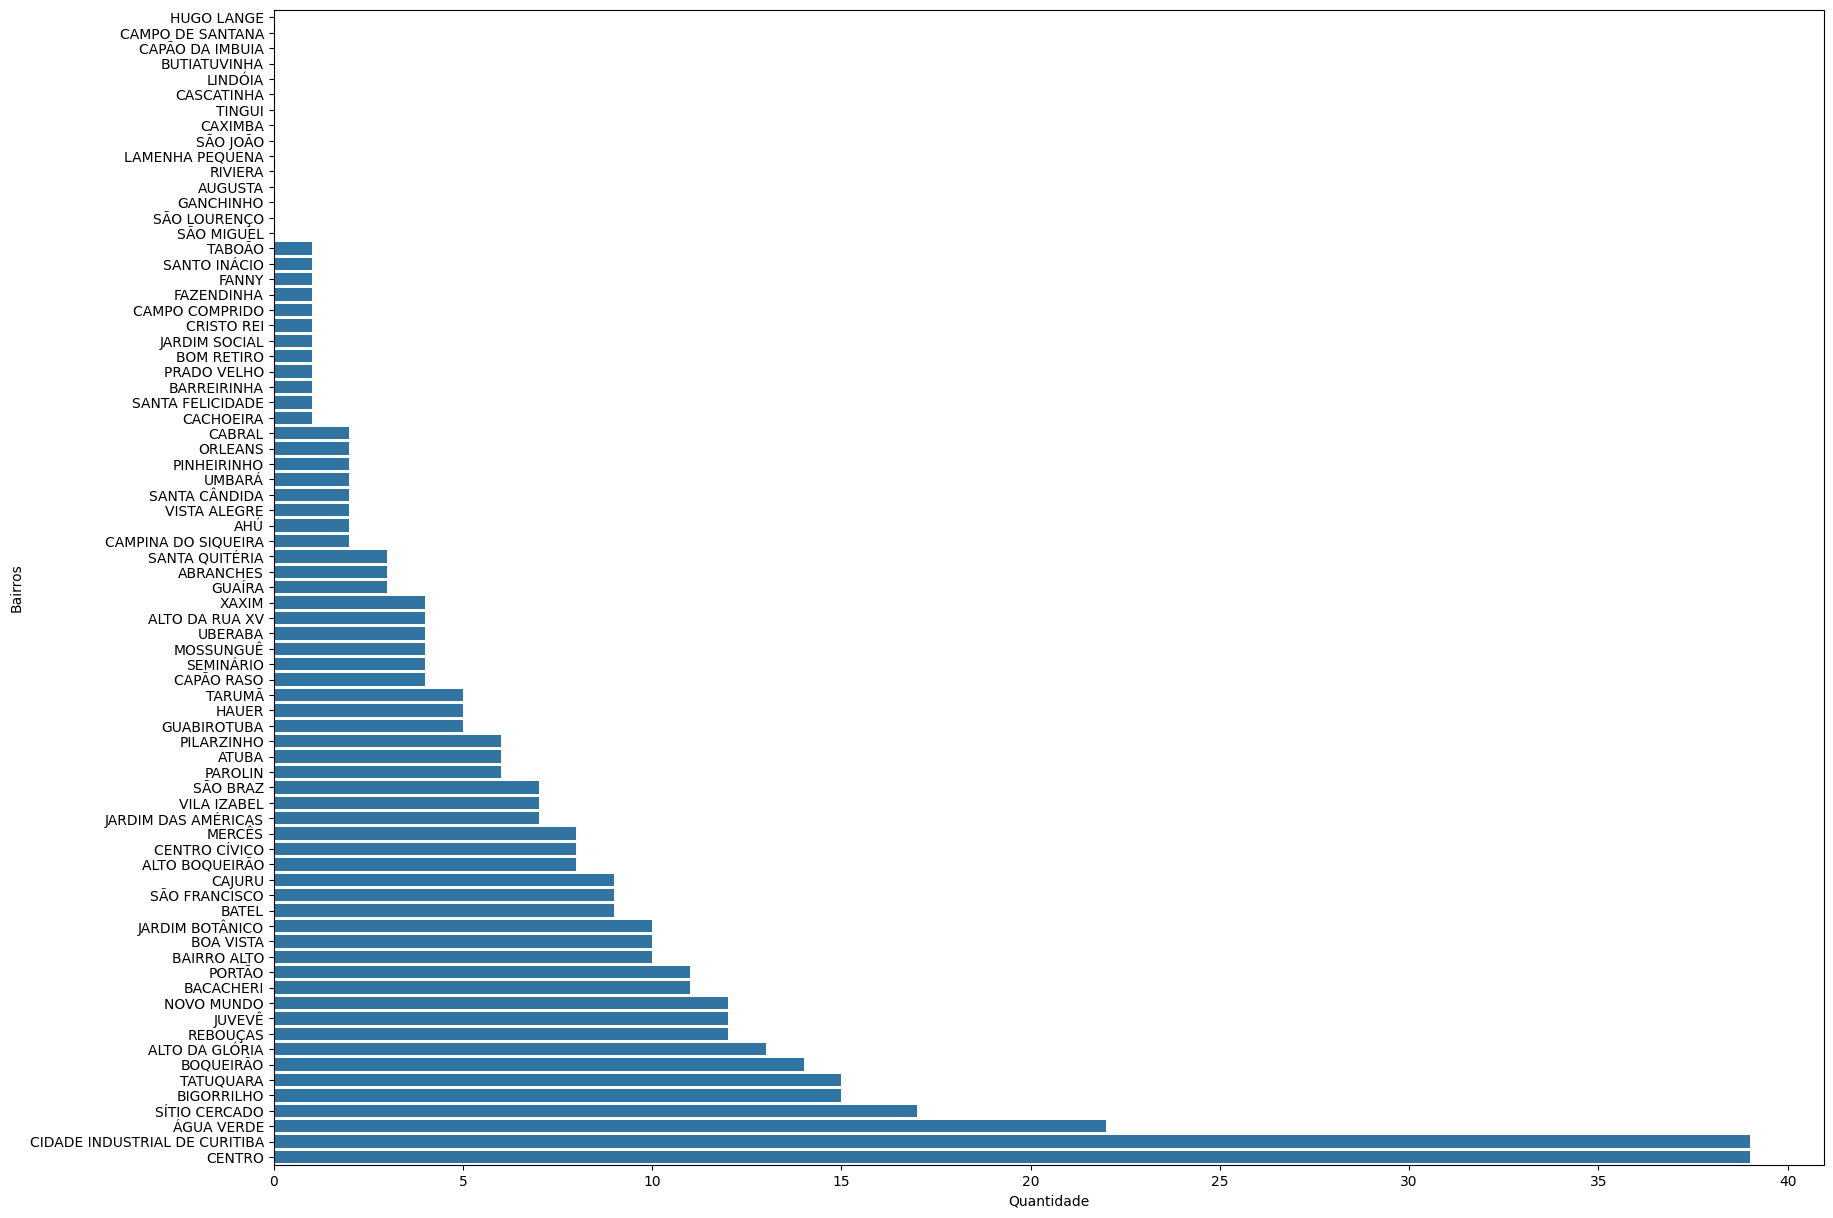

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
result = bairros.groupby(["NOME"])['number of points'].aggregate(np.median).reset_index().sort_values('number of points')
plt.figure(figsize=(20,15))
sns.barplot(y='NOME',x='number of points', data = result)
plt.xlabel('Quantidade')
plt.ylabel('Bairros')
plt.show()